# Assignment 3 - Geometry

University of Puerto Rico, Río Piedras    
Rémi Mégret, Introduction to Computer Vision    
Feb 2018

__Submitted by: Tatiana Castro Vélez

In [1]:
# Global imports
%matplotlib inline
import skimage
from skimage import data, io, color, filters, measure, feature
import matplotlib.pyplot as plt
import numpy as np
import skdemo

from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Add more imports here if needed

import glob, os

## Part A. Theoretical questions

__Q1.__ Typical discrete features (interest points) for the automatic alignment of images are typically computed in two steps: detection and description. Explain what is the role of each step, and provide for each of them at least 2 expected properties (i.e. what properties should a good discrete feature detector have; what properties should a good feature descriptor have?)

The step of detection has the purpose of providing a representation that allows to efficiently match structures in the images. Two expected properties that a good detector should have are repeatability and accuracy. Reapeatability means that it should be ableto detect the same features of the same scene or object repeatedly under variety of viewing conditions. Accuracy means that it should accurately localize the image features, especially for image matching tasks, where precise correspondences are needed to estimate the geometry.

The step of description is the invariant feature vector representation for a data image. Two properties of a good descriptor is invariance to shape transformation, this is regards noise or deformations, and the accuracy of the information content used for shape displacement. 

__Q2.__ In the context of the estimation of a geometrical model from data (line, circle, homography transformation...), what does **robust** estimation means?

Robust estimation is a thorough process in which you detect and match which generates raw matches. A popular robust estimation is using RANSAC 

__Q3.__ Why do we need to extract Canny edges before trying to fit a geometric figure (circle...) to a grey-level image?

You need to extract the Canny edges to a grey level image because this operator detects a wide range of edges in images which is needed to determine what figure you are dealing with. 

## Part B. Problem

__Objective:__ Use automatic image alignment for augmented reality: use automatic image alignment and image composition to replace planar patterns in a real image.

More specifically, the objective can be achieved in two steps:
1. Align automatically a template image onto the test image
2. Use the estimated projective transformation to replace the template image with another template of the same size inside the test image

For example:
![alt text](images/example.jpg "Example")

We consider in the following clown images:
- Image 1: a template image containing a planar pattern to detect
- Image 1a: an alternate template image to replace the template image
- Image 2: a test image that contains the planar pattern but seen from a different point of view

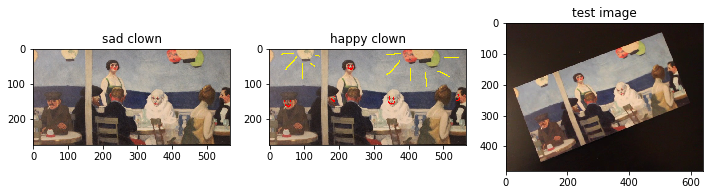

In [2]:
img1 = io.imread('images/clown0.jpg')
img1a = io.imread('images/clown0_alt.jpg') # Make the clown happy
img2 = io.imread('images/clown2.jpg')

fig,axes = plt.subplots(1,3,figsize=(12,4))
axes[0].imshow(img1)
axes[0].set_title('sad clown')
axes[1].imshow(img1a)
axes[1].set_title('happy clown')
axes[2].imshow(img2)
axes[2].set_title('test image');

## Step 1: Alignment

Estimate the projective transformation from img1 to img2 using discrete features.

In [3]:
from skimage.color import rgb2gray

pano0 = rgb2gray(img1a)
pano1 = rgb2gray(img2)
#pano2 = rgb2gray(img1a)

In [4]:
from skimage.feature import ORB

# Initialize ORB
# This number of keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=700, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

#orb.detect_and_extract(pano2)
#keypoints1 = orb.keypoints
#descriptors1 = orb.descriptors

In [5]:
print (keypoints0)
print(keypoints0.shape)

print(descriptors0)
print(descriptors0.shape)

[[ 137.        357.      ]
 [ 136.        346.      ]
 [ 151.        343.      ]
 ..., 
 [ 203.046912  418.03776 ]
 [  55.        236.      ]
 [ 239.04      462.24    ]]
(700, 2)
[[False  True False ...,  True  True False]
 [False False False ...,  True  True False]
 [False  True  True ...,  True  True  True]
 ..., 
 [False False False ...,  True False False]
 [ True  True  True ..., False False  True]
 [ True False False ...,  True False  True]]
(700, 256)


In [6]:
from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)

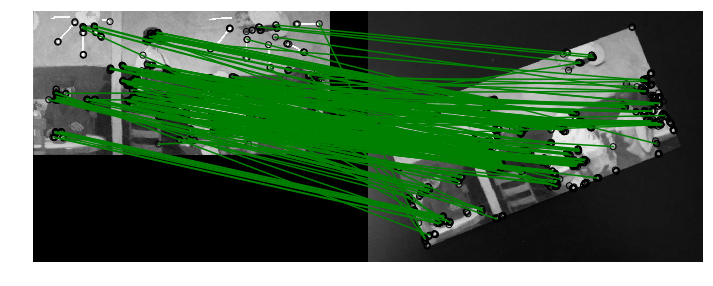

In [7]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01, matches_color="g")

ax.axis('off');

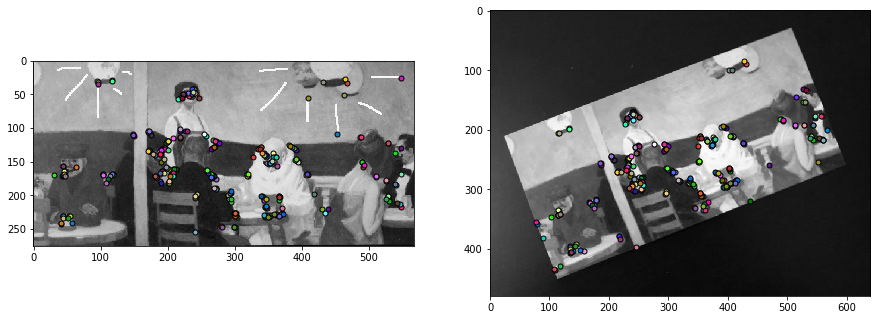

In [8]:
fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(pano0, cmap='gray')
axes[1].imshow(pano1, cmap='gray')

#id0 is a number that represents a indexes of rows in keypoints0

for row in range(matches01.shape[0]):
#row = 6
    id0, id1= matches01[row,:]

    x0= keypoints0[id0,1]
    y0= keypoints0[id0,0]

    x1= keypoints1[id1,1]
    y1= keypoints1[id1,0]

    col = np.random.rand(3)
    axes[0].plot(x0,y0,'o', color=col,markersize=5, markeredgecolor='k')
    axes[1].plot(x1,y1, 'o', color=col, markersize=5, markeredgecolor='k')

In [9]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0], ::-1]
dst = keypoints1[matches01[:, 1], ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

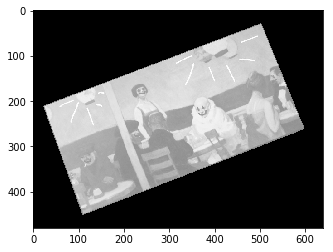

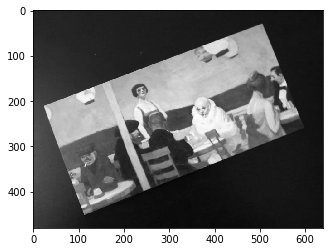

In [10]:
from skimage.transform import warp

from skimage.transform import SimilarityTransform

offset1= SimilarityTransform(translation=(200,0))
shape= np.array(pano1.shape)

# Warp pano0 to pano1
transform01 = (model_robust01).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=shape, cval=-1)

#pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
#pano0_warped[~pano0_mask] = 0      # Return background values to 0

plt.imshow(pano0_warped, cmap='gray')
fig = plt.figure()
plt.imshow(pano1, cmap='gray')

In [11]:
from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = img1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

In [12]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

# Translate pano1 into place
pano1_warped = warp(pano1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

In [13]:
from skimage.morphology import erosion 

pano1_mask = erosion(pano1_mask)
pano1_mask = erosion(pano1_mask)

In [14]:
# Warp pano0 to pano1
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

In [15]:
pano0_mask = erosion(pano0_mask)
pano0_mask = erosion(pano0_mask)

## Step 2: Composition

Use the projective transformation estimated previously to project img1 (or an alternate version of it) onto img2 and make the clown happy in the test image.

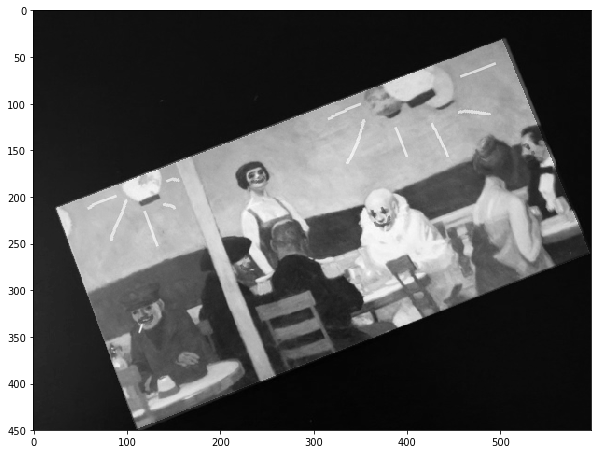

In [16]:
# Your code here (use several cells if needed)
# Add the three warped images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (pano1_warped*pano1_mask) + (pano0_warped*pano0_mask)  ## Sum warped images
fig = plt.figure(figsize=(10,15))
plt.imshow(merged, cmap='gray')

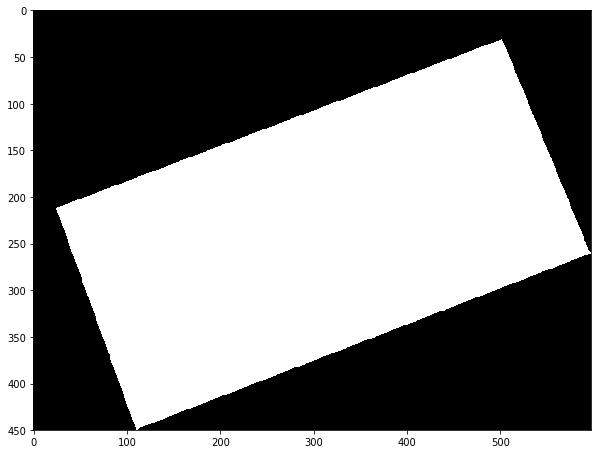

In [17]:
# Track the overlap by adding the masks together
overlap =  (pano0_mask *1) + pano1_mask## Sum masks
fig = plt.figure(figsize=(10,15))
plt.imshow(overlap, cmap='gray')
#colorbars()

In [18]:
# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged/np.maximum(overlap,1)   ## Divisor here

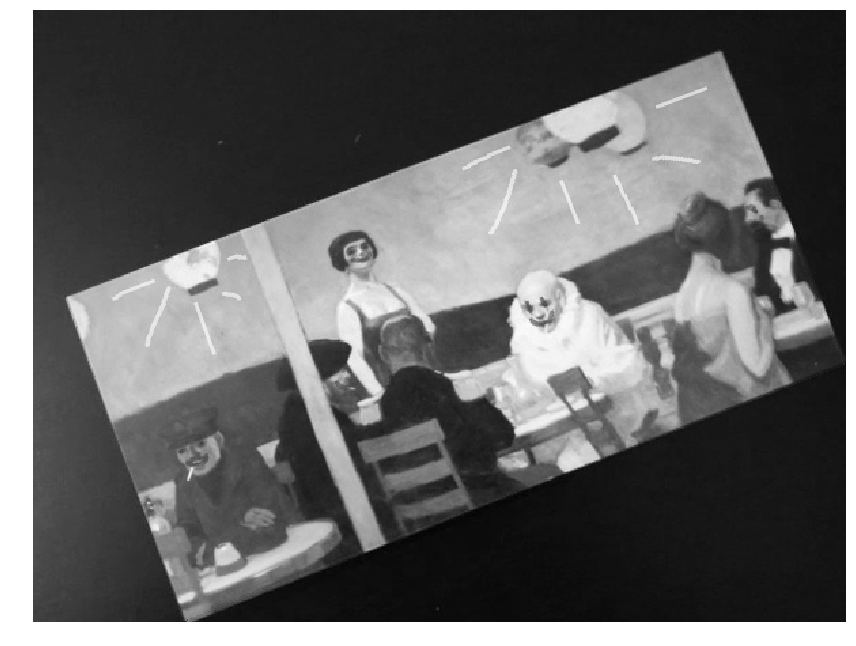

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized, cmap='gray')

fig.tight_layout()
ax.axis('off');

## Application to video

Apply the previous process to a video and generate the output video with the content swapped.

You may use the clown video provided, or any other video showing a moving planar object.

In [20]:
def dataset_align(img1, img2):
    pano0 = rgb2gray(img1)
    pano1 = rgb2gray(img2)
    
    orb = ORB(n_keypoints=700, fast_threshold=0.05)

    orb.detect_and_extract(pano0)
    keypoints0 = orb.keypoints
    descriptors0 = orb.descriptors

    orb.detect_and_extract(pano1)
    keypoints1 = orb.keypoints
    descriptors1 = orb.descriptors
    
    matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
    
    for row in range(matches01.shape[0]):
        id0, id1= matches01[row,:]

        x0= keypoints0[id0,1]
        y0= keypoints0[id0,0]

        x1= keypoints1[id1,1]
        y1= keypoints1[id1,0]

        col = np.random.rand(3)
        
    src = keypoints0[matches01[:, 0], ::-1]
    dst = keypoints1[matches01[:, 1], ::-1]

    model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)
    offset1= SimilarityTransform(translation=(200,0))
    shape= np.array(pano1.shape)

    transform01 = (model_robust01).inverse
    pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=shape, cval=-1)
    r, c = img1.shape[:2]

    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    warped_corners01 = model_robust01(corners)

    all_corners = np.vstack((warped_corners01, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)

    output_shape = np.ceil(output_shape[::-1]).astype(int)
        
    offset1 = SimilarityTransform(translation= -corner_min)

    pano1_warped = warp(pano1, offset1.inverse, order=3,
                            output_shape=output_shape, cval=-1)

    pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
    pano1_warped[~pano1_mask] = 0
        
    pano1_mask = erosion(pano1_mask)
    pano1_mask = erosion(pano1_mask)
        
    transform01 = (model_robust01 + offset1).inverse
    pano0_warped = warp(pano0, transform01, order=3,
                        output_shape=output_shape, cval=-1)

    pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
    pano0_warped[~pano0_mask] = 0  
        
    pano0_mask = erosion(pano0_mask)
    pano0_mask = erosion(pano0_mask)
        
    merged = (pano1_warped*pano1_mask) + (pano0_warped*pano0_mask)  ## Sum warped images
        
    overlap =  (pano0_mask *1) + pano1_mask## Sum masks

    normalized = merged/np.maximum(overlap,1)
    
    return normalized

Note: to process a video, the simplest it to extract each frame using ffmpeg and then compress it back together:
Extract frames:

```
mkdir out
mkdir in
ffmpeg -i inputvideo.mp4 -an in/frame%05d.png
```
process the images and save the result in directory `out/` then compress back:
```
ffmpeg -r 60 -f image2 -i out/frame%05d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p outputvideo.mp4
```

In [21]:
path="in/"
imlist= glob.glob(os.path.join(path, '*.png'))

In [22]:
for i, file in enumerate(imlist):
    image = io.imread(file)
    normalized1 = dataset_align(img1a, image)
    
    io.imsave("out/frame"+ format(i+1, '05d')+".png",normalized1)

/Users/tatianacastro/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/Users/tatianacastro/anaconda3/lib/python3.6/site-packages/skimage/transform/_geometric.py:554: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 0] /= dst[:, 2]
/Users/tatianacastro/anaconda3/lib/python3.6/site-packages/skimage/transform/_geometric.py:555: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 1] /= dst[:, 2]
/Users/tatianacastro/anaconda3/lib/python3.6/site-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/Users/tatianacastro/anaconda3/lib/python3.6/site-packages/skimage/transform/_geometric.py:555: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 1] /= dst[:, 2]
/Users/tatianacastro/anaconda3/lib/python3.6/site-packages/